## CPAL versus Deep Active Learning Baselines on Synthetic Spiral

In this tutorial, we walk through how to use CPAL (with two-layer ReLU Networks), linear cutting-plane active learning, DeepAL baselines, and Skactive baselines on a binary classification task using a synthetic spiral.

In [ ]:
import sys
sys.path.append('..')
from src.cpal.cpal import *
from src.baselines.linear_cp import *
from types import SimpleNamespace
from deepal_baseline.deepal_class import run_active_learning
from src.baselines.evaluation import *
from src.cpal.synthetic_data import *
from src.cpal.plot import *

### (1). Generate synthetic data

In [3]:
X_all, y_all, X, y, X_test, y_test = generate_spiral_data()

### (2). Sample hyperplane arrangements

In [4]:
dmat = generate_hyperplane_arrangement(X = X, P = 1000)
n_train, m = dmat.shape
print(f'dmat shape: {dmat.shape}')

dmat shape: (80, 623)


### (3). CPAL with two-layer ReLU networks (Before-Final-Solve vs. After-Final-Solve)

In [5]:
C, c, used = cutting_plane('c',X, y, dmat, n_points = 20)
print(f'used: {used}')

Solver MOSEK succeeded!
Cutting at iteration 0
Cutting at iteration 0
Solver MOSEK succeeded!
Cutting at iteration 1
Solver MOSEK succeeded!
Cutting at iteration 8
Solver MOSEK succeeded!
Cutting at iteration 16
Cutting at iteration 16
Solver MOSEK succeeded!
Cutting at iteration 17
Solver MOSEK succeeded!
Cutting at iteration 21
Solver MOSEK succeeded!
Cutting at iteration 24
Solver MOSEK succeeded!
Cutting at iteration 25
Cutting at iteration 25
Solver MOSEK succeeded!
Cutting at iteration 27
Solver MOSEK succeeded!
Cutting at iteration 29
Solver MOSEK succeeded!
Cutting at iteration 35
Cutting at iteration 35
Solver MOSEK succeeded!
Cutting at iteration 40
Cutting at iteration 40
Solver MOSEK succeeded!
used: [0, 0, 29, 55, 25, 27, 2, 65, 13, 18, 30, 5, 47, 14, 3, 52, 52]


In [9]:
n_train, m = dmat.shape
d = X.shape[1]
theta_matrix = np.reshape(c, (2*d,m), order ='F') # the resulting theta_matrix is of shape (2d, m)
Uopt1_v = theta_matrix[:d]
Uopt2_v = theta_matrix[d:]
# do the final convex solve
Uopt1_final_v, Uopt2_final_v, _ = convex_solve(used, X, y, dmat)

In [11]:
print('------------')
print('Model evaluation for CPAL (before final convex solve).')
evaluate_model_performance(task = 'c', X_test = X_test, y_test = y_test, Uopt1 = Uopt1_v, Uopt2 = Uopt2_v, X_train = X, y_train = y)

------------
Model evaluation for CPAL (before final convex solve).
Convex Model (CVX):
  # correct on test set:  12
  accuracy on test set:  0.6000
  # correct on train set: 67
  accuracy on train set: 0.8375


{'cvx_correct_test': 12,
 'cvx_acc_test': 0.6,
 'cvx_correct_train': 67,
 'cvx_acc_train': 0.8375}

In [12]:
print('------------')
print('Model evaluation for CPAL (after final convex solve).')
evaluate_model_performance(task = 'c', X_test = X_test, y_test = y_test, Uopt1 = Uopt1_final_v, Uopt2 = Uopt2_final_v, X_train = X, y_train = y)

------------
Model evaluation for CPAL (after final convex solve).
Convex Model (CVX):
  # correct on test set:  20
  accuracy on test set:  1.0000
  # correct on train set: 80
  accuracy on train set: 1.0000


{'cvx_correct_test': 20,
 'cvx_acc_test': 1.0,
 'cvx_correct_train': 80,
 'cvx_acc_train': 1.0}

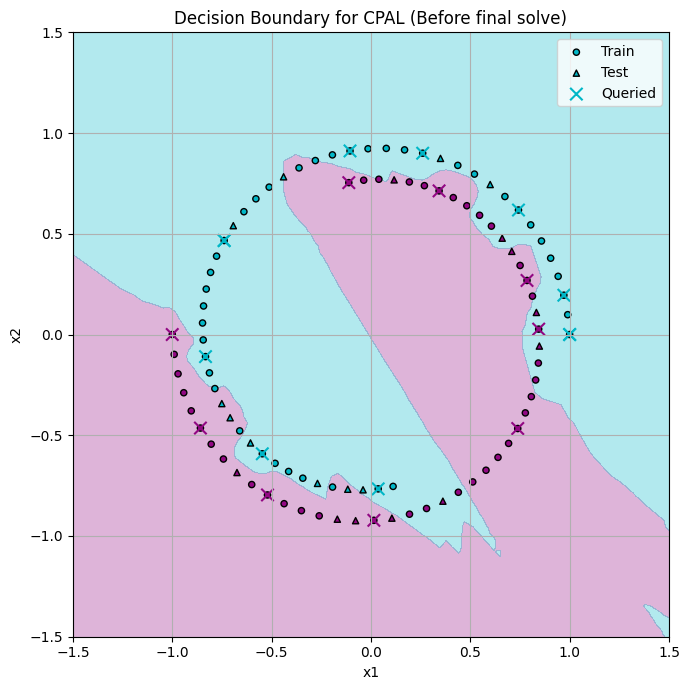

In [14]:
# plot decision boundary for both
plot_decision_boundary(
    X=X,
    y=y,
    X_test=X_test,
    y_test=y_test,
    name='Decision Boundary for CPAL (Before final solve)',
    selected_indices = used,
    Uopt1v=Uopt1_v,
    Uopt2v=Uopt2_v,
    plot_type='cvx'
)

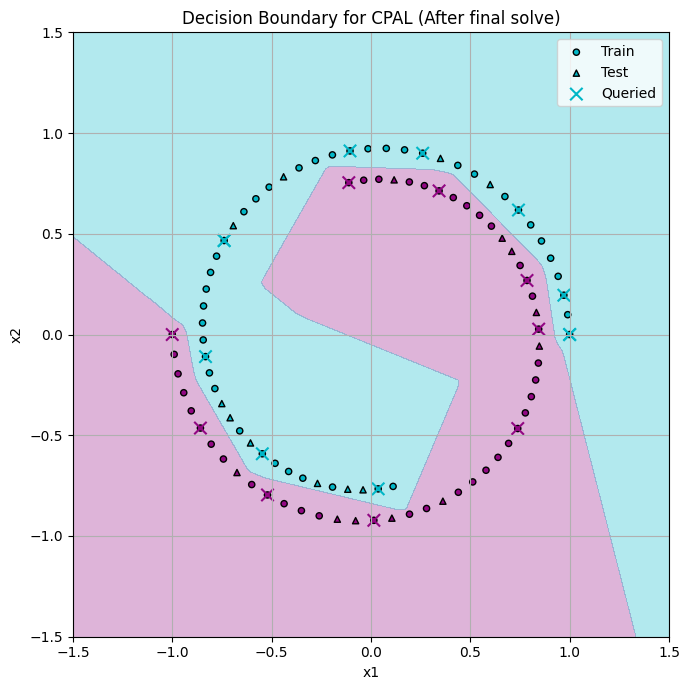

In [15]:
plot_decision_boundary(
    X=X,
    y=y,
    X_test=X_test,
    y_test=y_test,
    selected_indices=used,
    name='Decision Boundary for CPAL (After final solve)',
    Uopt1v=Uopt1_final_v,
    Uopt2v=Uopt2_final_v,
    plot_type='cvx'
)

### (4). Linear Cutting-Plane Baseline

In [7]:
C, c, used = linear_cutting_plane_classification(X, y, m, 20)
print(f'used: {used}')

Cutting at iteration 0
Cutting at iteration 1
Cutting at iteration 2
Cutting at iteration 3
Cutting at iteration 4
Cutting at iteration 5
Cutting at iteration 6
Cutting at iteration 7
Cutting at iteration 8
Cutting at iteration 9
Cutting at iteration 10
Cutting at iteration 11
Cutting at iteration 12
Cutting at iteration 13
Cutting at iteration 14
Cutting at iteration 15
Cutting at iteration 16
Cutting at iteration 17
Cutting at iteration 18
Cutting at iteration 19
used: [57, 53, 18, 66, 61, 15, 71, 54, 35, 0, 17, 58, 16, 76, 70, 36, 46, 6, 45, 68]


Accuracy on training set: 50.00%
Accuracy on test set: 50.00%


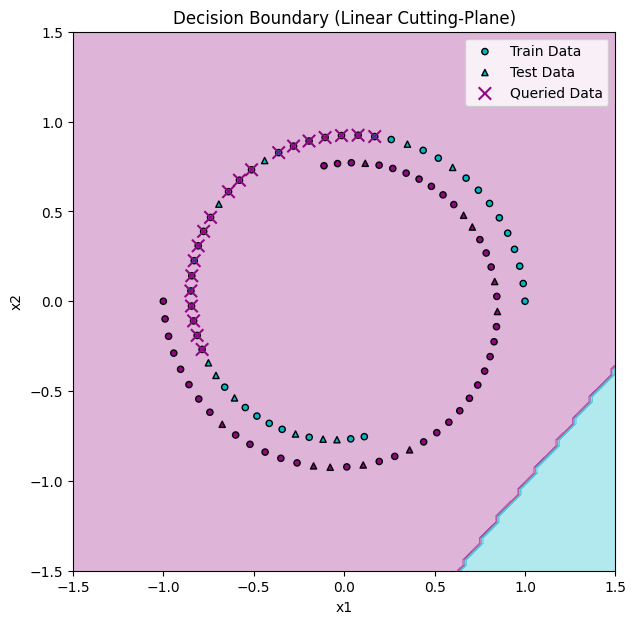

In [8]:
plot_decision_boundary_linear(X_all, X, y, X_test, y_test, c, used)

### (5). Run DeepAL baselines

In [ ]:
deepal_selected_indices = []
deepal_strategies = ["RandomSampling", "LeastConfidence", "EntropySampling","KMeansSampling", "BALDDropout"]


for al in deepal_strategies:
    args = SimpleNamespace(
        seed=1,
        n_init_labeled=1,
        n_query=1,
        n_round=14,
        dataset_name='Spiral',
        strategy_name=al,
        save_dir="class_plots",
        save_pickle="class_accuracy"
    )

    selected_indices, rmse_train, rmse_test, strategy, dataset, net, device = run_active_learning(args)
    deepal_selected_indices.append(selected_indices)

number of labeled pool: 1
number of unlabeled pool: 79
number of testing pool: 20

Round 0


  0%|                                                                      | 0/2000 [00:00<?, ?it/s]